In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
from src.band_plotters import DATA_DIRECTORY

In [3]:
FINGERPRINT_NAME = "all_k_branches_histogram_all_energies"
    
FINGERPRINT_LENGTH = 60
PERPLEXITY = 30
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

all_k_branches_histogram_all_energies


To make a new finerprint all you need to change is the constants above and/or the calc_fingerprint function below.
# All K Branches Histogram Fingerprint
Bin all energy values between -8 and +8 eV for each branch in K space.

## Start with Anupam's list of materials

In [10]:
df_material = pd.read_csv("../fingerprints/template.csv", index_col="ID")
df_material.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat,relative_id,crystal_system
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4963,trigonal
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3279,trigonal
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2,2dm-5155,triclinic
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4342,trigonal
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3574,trigonal


## Fingerprint Functions Here
Fingerprint functions take material ID as only input

In [11]:
def calc_all_k_branches_histogram_fingerprint(material_id, fingerprint_length=FINGERPRINT_LENGTH, e_range=None, normalize=False, shifted=True):
    filename_bands=DATA_DIRECTORY/f"bands/{material_id}.json"
    if not filename_bands.exists():
        print(f"No such file {filename_bands}")
        
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    if shifted:
        energies -= bands_dict["efermi"]

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]

        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range, density=normalize)

        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint

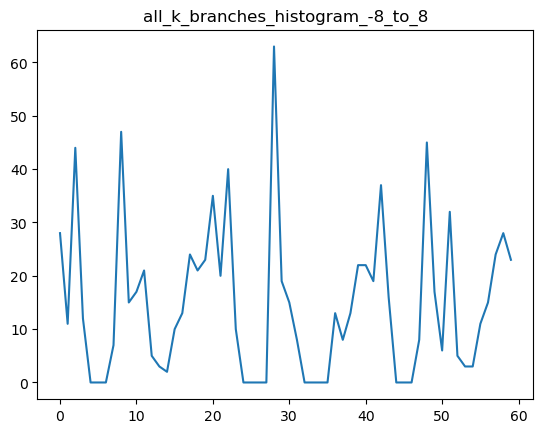

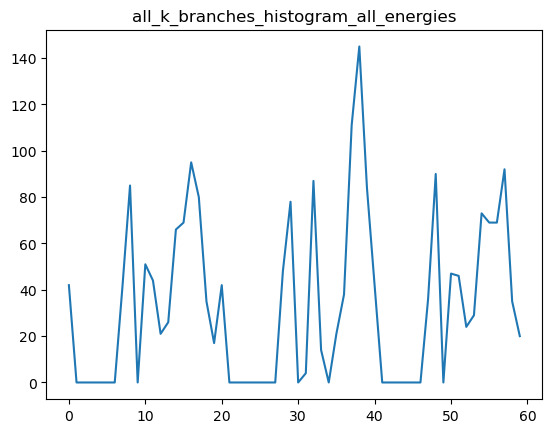

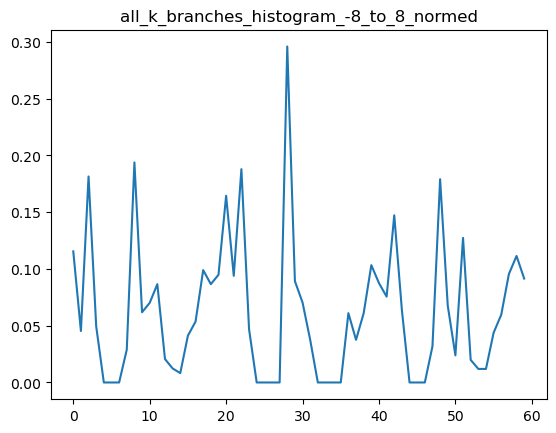

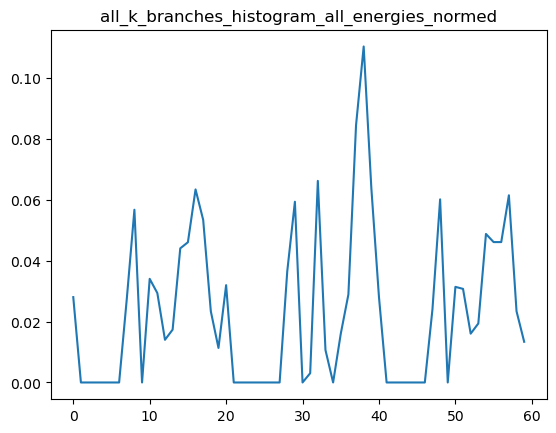

In [12]:
fingerprint_functions = {
    "all_k_branches_histogram_-8_to_8": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=False),
    "all_k_branches_histogram_all_energies": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=False),
    "all_k_branches_histogram_-8_to_8_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=True),
    "all_k_branches_histogram_all_energies_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=True),
}

for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("2dm-1")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

In [13]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [14]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 5270
100 / 5270
200 / 5270
300 / 5270
400 / 5270
500 / 5270
600 / 5270
700 / 5270
800 / 5270
900 / 5270
1000 / 5270
1100 / 5270
1200 / 5270
1300 / 5270
1400 / 5270
1500 / 5270
1600 / 5270
1700 / 5270
1800 / 5270
1900 / 5270
2000 / 5270
2100 / 5270
2200 / 5270
2300 / 5270
2400 / 5270
2500 / 5270
2600 / 5270
2700 / 5270
2800 / 5270
2900 / 5270
3000 / 5270
3100 / 5270
3200 / 5270
3300 / 5270
3400 / 5270
3500 / 5270
3600 / 5270
3700 / 5270
3800 / 5270
3900 / 5270
4000 / 5270
4100 / 5270
4200 / 5270
4300 / 5270
4400 / 5270
4500 / 5270
4600 / 5270
4700 / 5270
4800 / 5270
4900 / 5270
5000 / 5270
5100 / 5270
5200 / 5270
[[ 42.   0.   0. ...  92.  35.  20.]
 [ 42.   0.   0. ... 147. 131.  60.]
 [189. 567.   0. ... 107. 208. 156.]
 ...
 [ 42.   0. 126. ... 121. 217. 208.]
 [ 42.   0.   0. ...  54.  78.  37.]
 [ 42.   0.   0. ...  53.  71.  34.]]


In [15]:
#check for NaNs 
np.isnan(fingerprint_array).sum()

0

## Create T-SNE Reduced Dimension Fingerprints

In [16]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=PERPLEXITY ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5270 samples in 0.000s...
[t-SNE] Computed neighbors for 5270 samples in 0.513s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5270
[t-SNE] Computed conditional probabilities for sample 2000 / 5270
[t-SNE] Computed conditional probabilities for sample 3000 / 5270
[t-SNE] Computed conditional probabilities for sample 4000 / 5270
[t-SNE] Computed conditional probabilities for sample 5000 / 5270
[t-SNE] Computed conditional probabilities for sample 5270 / 5270
[t-SNE] Mean sigma: 135.456918
[t-SNE] Computed conditional probabilities in 0.364s
[t-SNE] Iteration 50: error = 80.2818680, gradient norm = 0.0190451 (50 iterations in 1.416s)
[t-SNE] Iteration 100: error = 76.5768585, gradient norm = 0.0050827 (50 iterations in 1.173s)
[t-SNE] Iteration 150: error = 75.9268799, gradient norm = 0.0026026 (50 iterations in 1.174s)
[t-SNE] Iteration 200: error = 75.6710358, gradient norm = 0.0016591 (50 iterations in 1.183s)


## Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [21]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

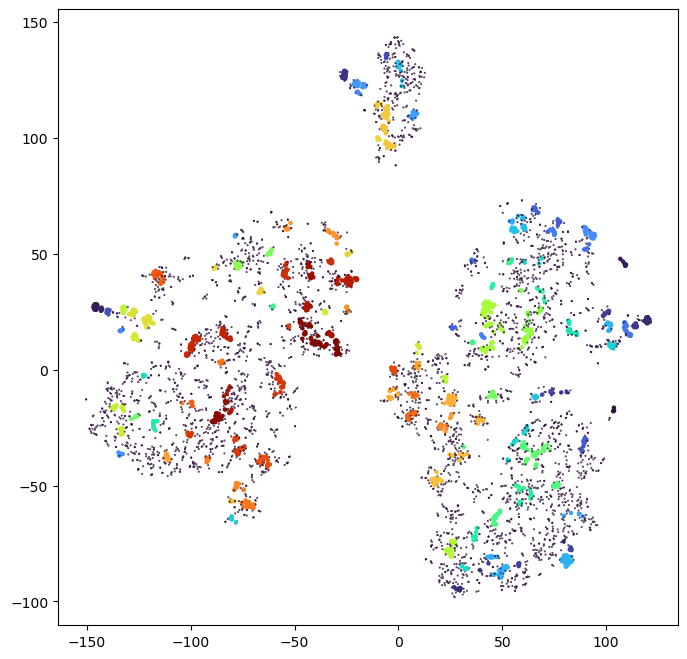

In [22]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")

## Add fingerprints, T-SNE to dataframe

In [23]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,52,53,54,55,56,57,58,59,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,24.0,29.0,73.0,69.0,69.0,92.0,35.0,20.0,-46.639133,9.739903
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,0.0,0.0,21.0,49.0,75.0,147.0,131.0,60.0,-72.038414,-57.428963
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,205.0,102.0,49.0,32.0,99.0,107.0,208.0,156.0,30.732214,36.278019
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,84.0,0.0,0.0,222.0,99.0,147.0,203.0,379.0,7.488275,130.662537
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,0.0,14.0,84.0,91.0,42.0,78.0,131.0,127.0,-87.820595,-20.226099


In [20]:
df.to_csv("../fingerprints/"+OUTPUT_NAME)